In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# Processing Libs 
import skimage as ski
import PIL.Image as Image

# NN libs'
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Neural Imaging Libs
import nibabel as nib
import nilearn as nl

#Getting helper scripts
from utils.data_loader import BraTSDatasetP1, BraTSDatasetP3, BraTSDatasetP2, get_brats_filepaths, build_cache, split_brats_dataset,patch_consistency_test
from utils.metrics import compare_pipelines_dice, DiceCELoss
from utils.unet import UNet3D, UNet3D_Optimized_2

from utils.train_unet import run_experiment
from utils.evaluate_unet import eval_experiment
from utils.seeding import set_global_seed
from utils.visualize import plot_losses_per_seed, plot_loss_summary, visualize_sample, visualize_patient_consistency, plot_model_comparison

In [2]:
# General Paths
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"

In [3]:
#Extract image and mask paths
trainingData_root_dir = os.path.join(RAW_DATA_PATH, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData") #create directory to data
image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 
print(mask_paths[354]) #Test Print


data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_seg.nii


In [4]:
#  Performing Patientwise split 
train_imgs, val_imgs, train_masks, val_masks = split_brats_dataset(
    image_paths, mask_paths, val_size=0.2, seed=42
)

print(f"Train patients: {len(train_imgs)}")
print(f"Val patients: {len(val_imgs)}")

# Derive patient IDs from the split lists
def pid_from_modalities(modality_paths):
    """
    modality_paths: list of 4 paths [flair, t1, t1ce, t2]
    Returns the patient folder name used in cache (e.g., 'BraTS20_Training_001').
    """
    return os.path.basename(os.path.dirname(modality_paths[0]))

train_pids = [pid_from_modalities(m) for m in train_imgs] #Extracting train patient IDs
val_pids   = [pid_from_modalities(m) for m in val_imgs] #Extracting val patient IDs

# Checking if lengths match
len(train_pids) == len(train_imgs), len(val_pids)  == len(val_imgs)

Train patients: 295
Val patients: 74


(True, True)

In [5]:
'''
Preparing directories to create Cache (saved image patches and volumes) for P2 and P3 using the split

'''
# Cache directories
cache_root = "data/processed/cache"
cache_train = os.path.join(cache_root, "train")
cache_val   = os.path.join(cache_root, "val")

In [6]:
'''
Creating datasets for each pipeline; P1, P2, P3

'''
from utils.data_loader import BraTSDatasetP1, BraTSDatasetP3, BraTSDatasetP2, get_brats_filepaths, build_cache, split_brats_dataset,patch_consistency_test


# # P1 (on the fly)
# train_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=True)
# val_dataset_P1   = BraTSDatasetP1(val_imgs,   val_masks,   augment=False)

# P2 (cached volumes)
train_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_train, "volumes"),
    patient_ids=train_pids,
    patch_size=(96,96,96),
    augment=True
)
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

# # P3 (cached patches)
# train_dataset_P3 = BraTSDatasetP3(
#     cache_dir=os.path.join(cache_train, "patches"),
#     patient_ids=train_pids,
#     augment=True
# )
# val_dataset_P3 = BraTSDatasetP3(
#     cache_dir=os.path.join(cache_val, "patches"),
#     patient_ids=val_pids,
#     augment=False
# )

In [10]:
# Instantiate all three datasets with augment=False
consistencyCheck_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=False) # P1 (on the fly)
consistencyCheck_dataset_P2 = BraTSDatasetP2(cache_dir=os.path.join(cache_train, "volumes"),patient_ids=train_pids,augment=False)# P2 (cached volumes)
consistencyCheck_dataset_P3 = BraTSDatasetP3(cache_dir=os.path.join(cache_train, "patches"),patient_ids=train_pids,augment=False)# P3 (cached patches)

In [22]:
batch_size = 1
num_workers = 4
'''
Preparing data for both training and validation (for all three pipelines : P1, P2, P3)
"run this before training"

'''
#  DataLoaders
# DataLoaders
# train_loader_P1 = DataLoader(
#     train_dataset_P1, batch_size=batch_size, shuffle=True,
#     num_workers=num_workers, pin_memory=True
# )
# val_loader_P1 = DataLoader(
#     val_dataset_P1, batch_size=batch_size, shuffle=False,
#     num_workers=num_workers, pin_memory=True
# )

train_loader_P2 = DataLoader(
    train_dataset_P2, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True
)
val_loader_P2 = DataLoader(
    val_dataset_P2, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

# train_loader_P3 = DataLoader(
#     train_dataset_P3, batch_size=batch_size, shuffle=True,
#     num_workers=num_workers, pin_memory=True
# )
# val_loader_P3 = DataLoader(
#     val_dataset_P3, batch_size=batch_size, shuffle=False,
#     num_workers=num_workers, pin_memory=True
    
# )


def train_loader_printout(train_loader):
    for img, mask in train_loader:
        print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
        print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
        break


# Fetch a batch (example print)
train_loader_printout(train_loader_P1), train_loader_printout(train_loader_P2), train_loader_printout(train_loader_P3)

Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])
Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])
Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])


(None, None, None)

In [14]:
from utils.run_train_eval import run_train_eval


epochs   = 30         # smoke test = 1, full ablation = 30
early_stopping = True
es_patience = 10         # full ablation = 10
lr       = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seeds for reproducibility
seeds = [0, 1, 2]   # smoke test = [42], full ablation = [0,1,2]

pipelines={
        "P1": (train_loader_P1, val_loader_P1),
        "P2": (train_loader_P2, val_loader_P2),
        "P3": (train_loader_P3, val_loader_P3),
    }

# define builders
model_fn      = lambda: UNet3D(in_ch=4, out_ch=4)
loss_fn_fn    = DiceCELoss
optimizer_fn  = lambda model: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler_fn  = lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(
                    opt, mode="min", factor=0.5, patience=5, min_lr=1e-6
)

df_hist, df_summary = run_train_eval(
    seeds=seeds,
    pipelines=pipelines,
    model_fn=model_fn,
    loss_fn_fn=loss_fn_fn,
    optimizer_fn=optimizer_fn,
    scheduler_fn=scheduler_fn,
    early_stopping = early_stopping,
    epochs=epochs,
    patience=es_patience,
    lr=lr,
    device=device,
    results_dir="results"
)


=== Seed 0 ===
Global seed set to 0

--- Pipeline P1 ---

=== Training UNet on P1_s0 ===


[Train] Epoch 1/30:   0%|                                                                      | 0/295 [00:26<?, ?it/s]


KeyboardInterrupt: 

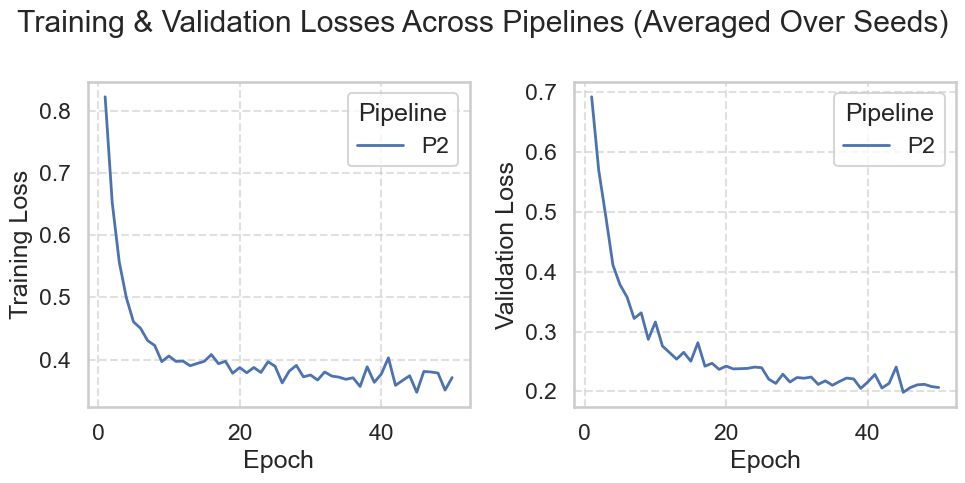

In [31]:
history_cvs = "results/model comparison/base/all_pipelines_history.csv"
figurename = "Allpipelines_TrainVal_loss"
plot_loss_summary(history_cvs,figurename)

Plot saved to results/images/Patient_random-89_consistency.png


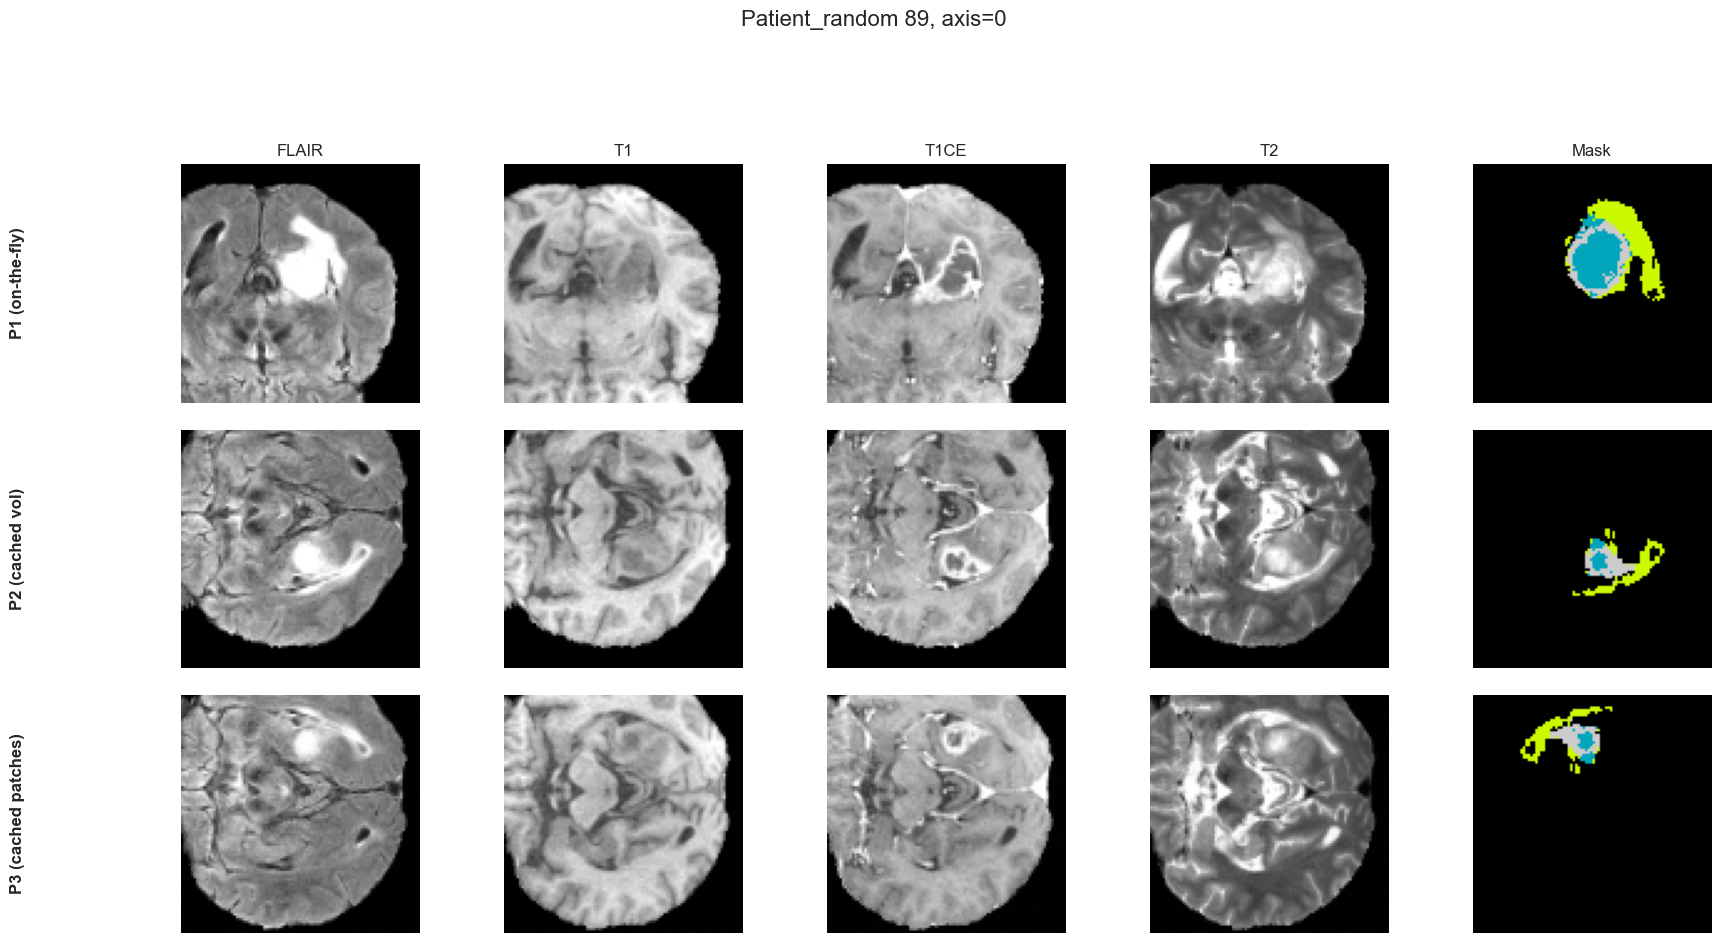

Plot saved to results/images/Patient_deterministic-89_consistency.png


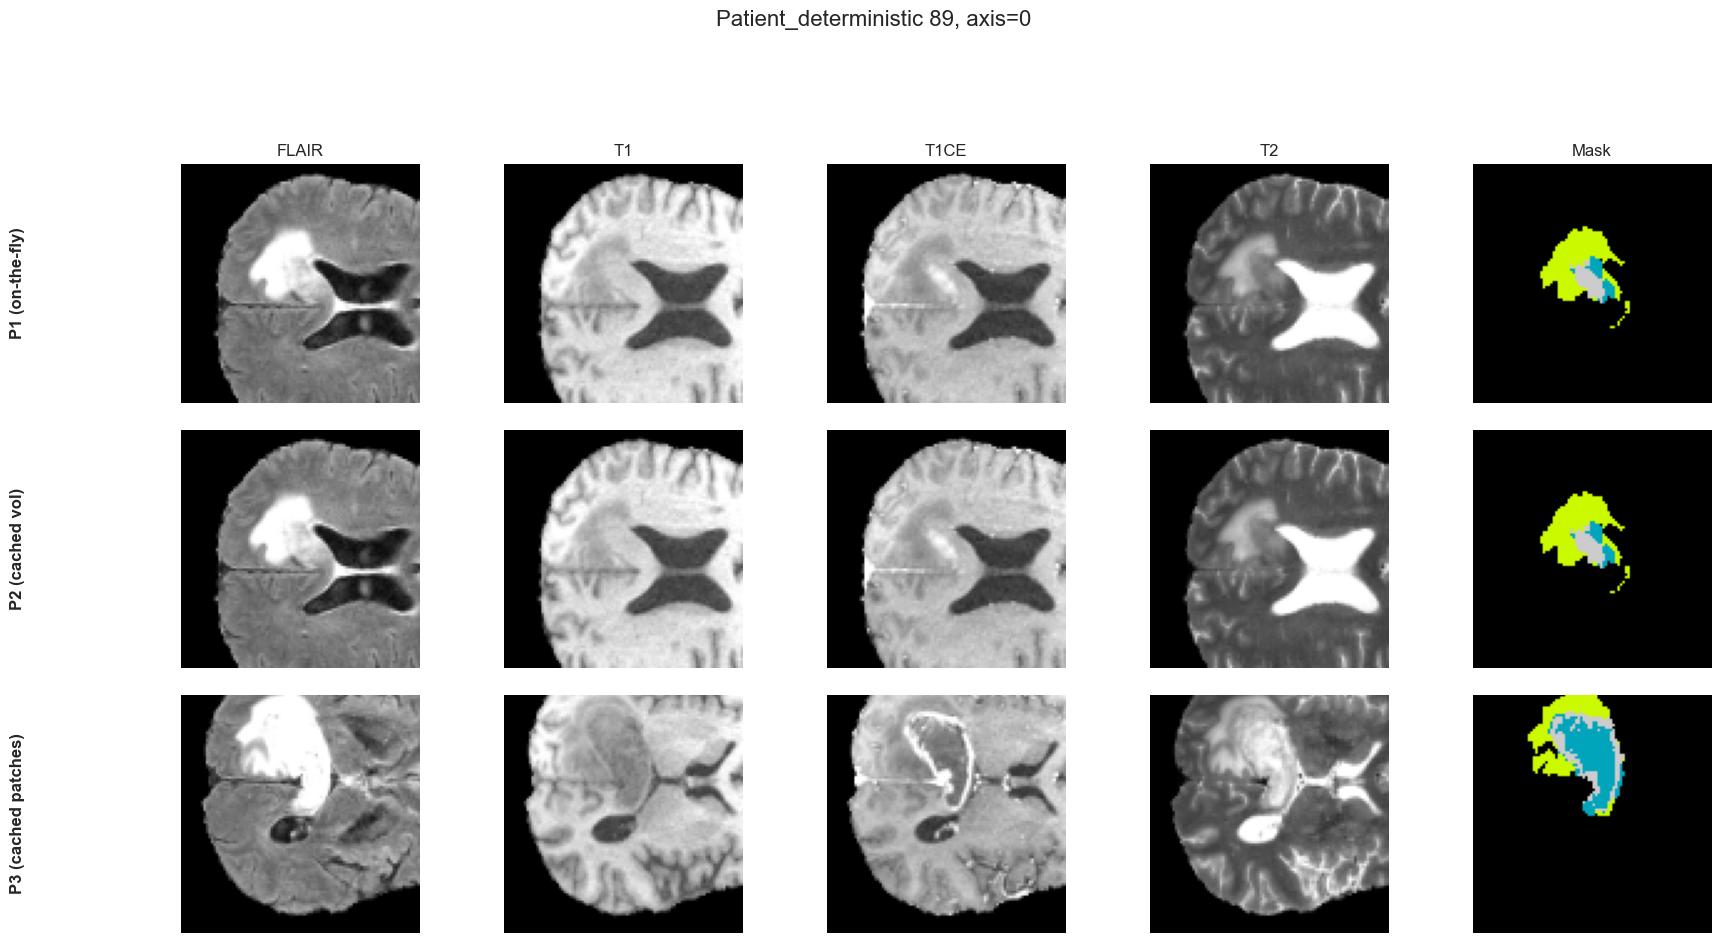

In [24]:
'''
Qualitative Sanity checks: 
Visualizing patches produced by the 3 pipelines -> mainly Checking for consistency of anatomical regions ("what the model sees!")
and integrity of data deterministically (seeded + no augmentations)
'''
#What the model really sees after all pipelines have been executed successfully (random patches)
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=89, seed = None)

#Seeded patch selection with No Augmentations just for sanity check of anatomical regions (Deterministic patches) 
visualize_patient_consistency(consistencyCheck_dataset_P1, consistencyCheck_dataset_P2, consistencyCheck_dataset_P3, patient_idx=89)

In [26]:
# ##Testing Evaluation
# ckpt =  "models/unet_P2_opt_s42.pth"
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seed = 5
# # # fresh model & optimizer per seed
# model = UNet3D_Optimized_1(
#     in_ch=4,
#     out_ch=4
#     ).to(device)
# #
# results = eval_experiment(model, val_loader_P2, ckpt, f"P2_s{seed}", device)

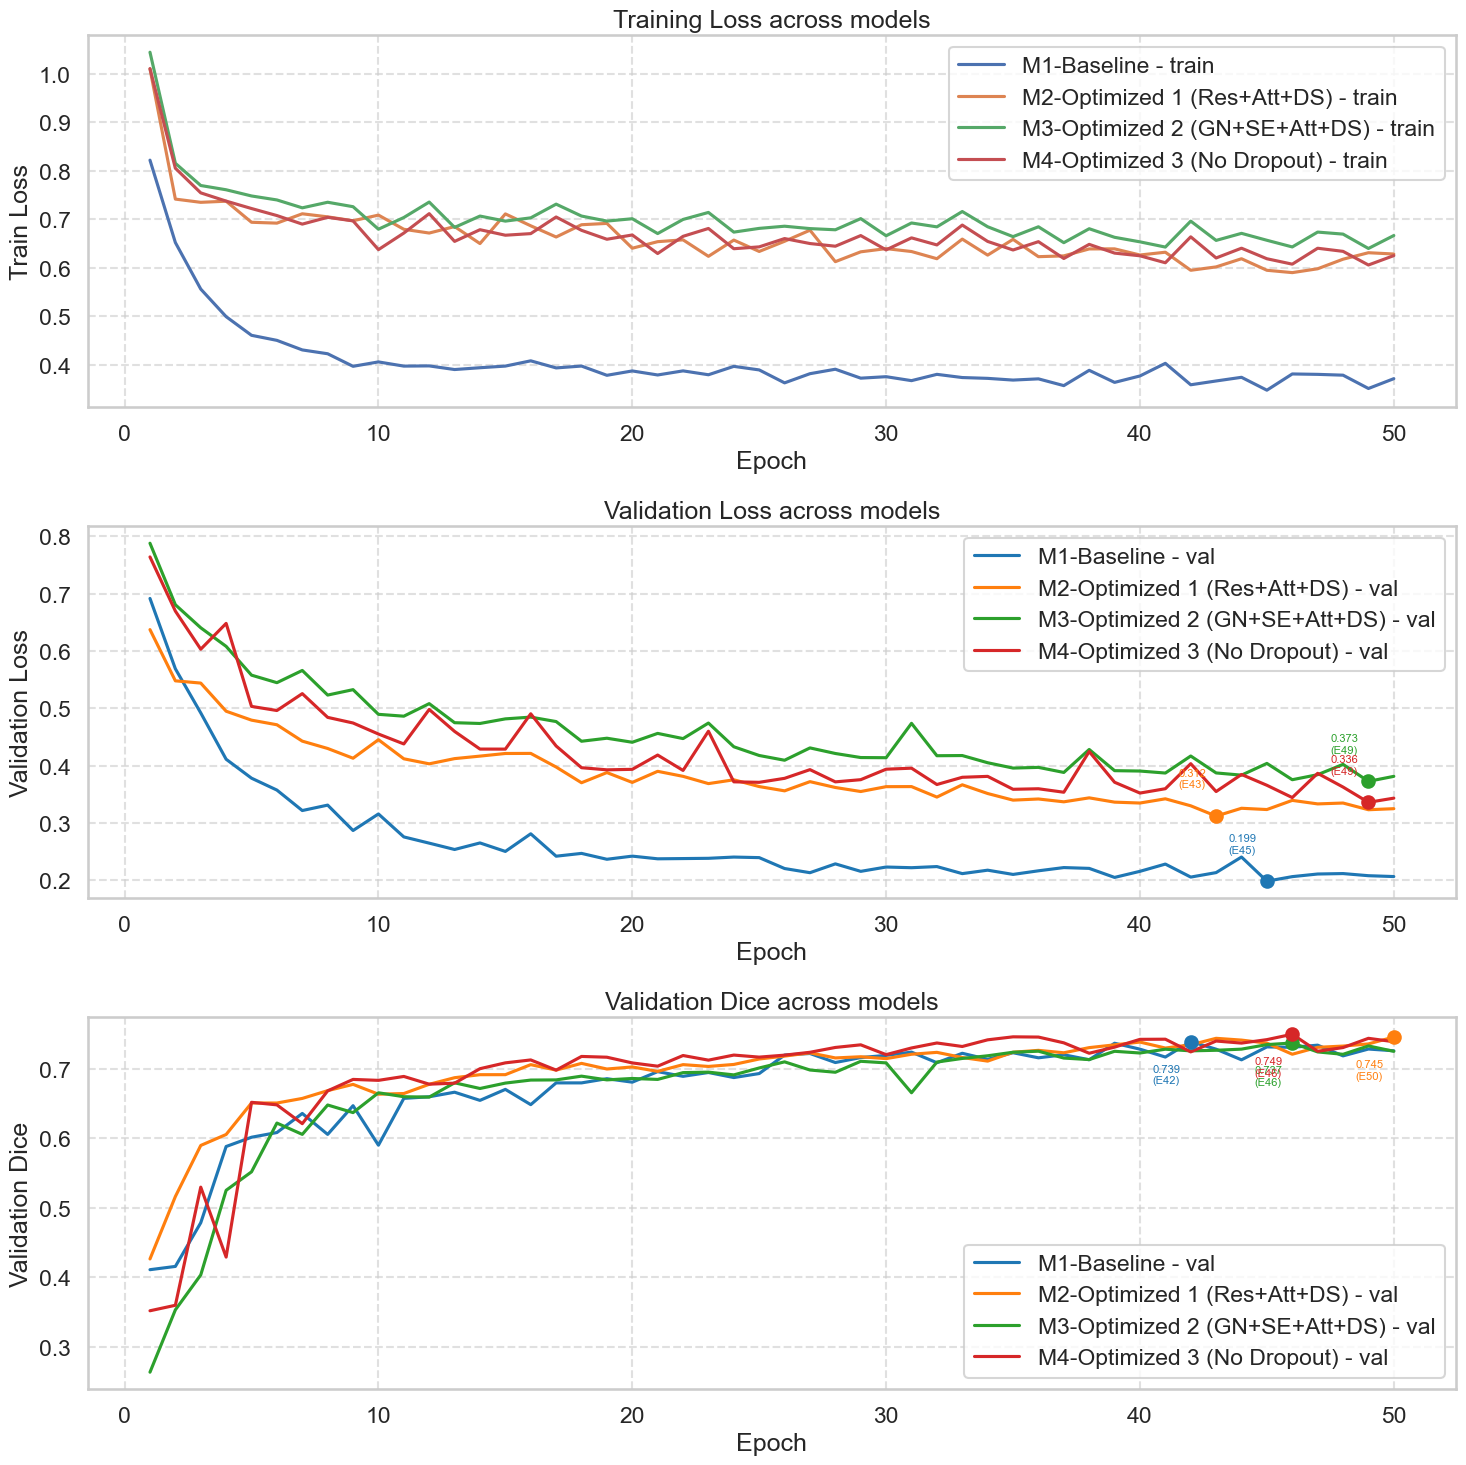

In [2]:
csv_files = [
    "results/model comparison/base/all_pipelines_history.csv",       # M1
    "results/model comparison/optimized/model1/Model_1_history.csv", # M2
    "results/model comparison/optimized/model2/Model_2_history.csv", # M3
    "results/model comparison/optimized/model2_Nodropout/Model_2_Nodropout_history.csv" # M4
]

labels = [
    "M1-Baseline", 
    "M2-Optimized 1 (Res+Att+DS)", 
    "M3-Optimized 2 (GN+SE+Att+DS)", 
    "M4-Optimized 3 (No Dropout)"
]

savepath = "results/Images/ModelComparison.png"

plot_model_comparison(csv_files, labels, savepath)
